# Embedded ML Lab - Excercise 2 - Quantization (additional experiments)

Until now, we always used a symmetric min/max scale for quantization of the activations, hence a centered zero point.

We will now do two things to squeeze a little bit more accuracy out of the quantization  
* Firstly, we will loosen our assumption of a symmetric range/zero_point
* Secondly, we will consider "cutting away" parts that are not important for the classification choice


In [133]:
from net import CifarNet
import torch

torch.backends.quantized.engine = 'qnnpack'

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)

import time
import nbimporter 
from utils import net_time
from utils import net_acc
from utils import fuse_conv_bn_weights
from utils import QCifarNet, QConv2dReLU, QLinear
from utils import tensor_scale

We introduce two changed Modules (`QConv2dreluNSym`, `QLinerNSym`) that besides a scale (like in the last exercise) also have an adjustable zero_point that can be also set through the state_dict.

We use these two Modules in a new Classifier called `QCifarNetSym`  

In [134]:
from torch.nn.quantized.modules.utils import _pair_from_first
import torch.nn as nn
import torch.nn.functional as F

#Both classes now also have a state-dict entry for the zero_point
class QConv2dReLUNSym(QConv2dReLU):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(QConv2dReLUNSym, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.register_buffer('zero_point', torch.tensor(64))

    def forward(self, x):
        return torch.ops.quantized.conv2d_relu(x, self._prepack, self.scale, self.zero_point)

    
class QLinearNSym(QLinear):
    def __init__(self, in_features, out_features):
        super(QLinearNSym, self).__init__(in_features, out_features)
        self.register_buffer('zero_point', torch.tensor(64))
   
    def forward(self, x):
        return torch.ops.quantized.linear(x, self._prepack, self.scale, self.zero_point)
    
    
class QCifarNetNSym(QCifarNet):
    def __init__(self):
        super(QCifarNet, self).__init__()
        
        self.register_buffer("scale", torch.tensor(0.1))

        self.conv1 = QConv2dReLUNSym(3, 16, 3, 1, padding=1)
        self.conv2 = QConv2dReLUNSym(16,16, 3, 1, padding=1)

        self.conv3 = QConv2dReLUNSym(16, 32, 3, 1, padding=1)
        self.conv4 = QConv2dReLUNSym(32, 32, 3, 1, padding=1)

        self.conv5 = QConv2dReLUNSym(32, 64, 3, 1, padding=1)
        self.conv6 = QConv2dReLUNSym(64, 64, 3, 1, padding=1)

        self.fc = QLinearNSym(1024, 10)


Your Task:
   * Copy your class description of `CifarNetCalibration` from the last lab into the next block.
   * Besides the calibration, add execute the function `plot_density` after each operator.
   * Run the calibration batch again (code provided) and inspect the figures. What observation can you make?

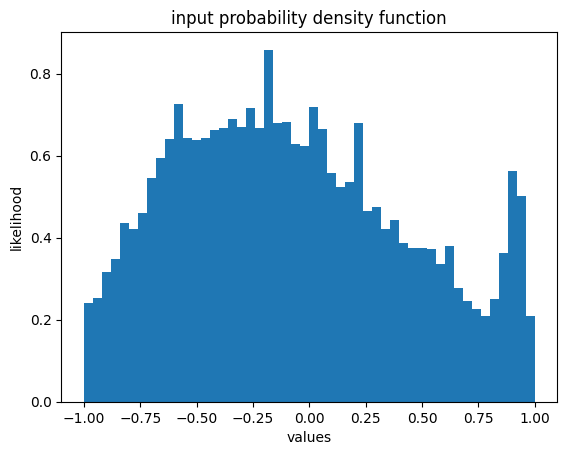

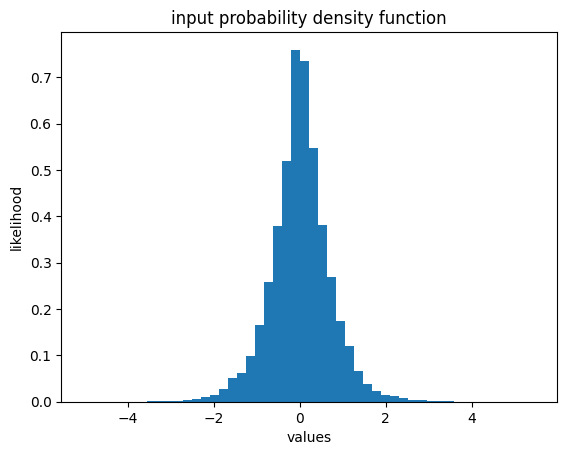

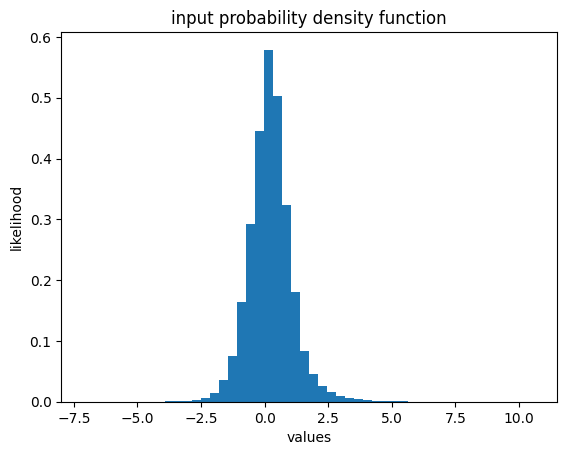

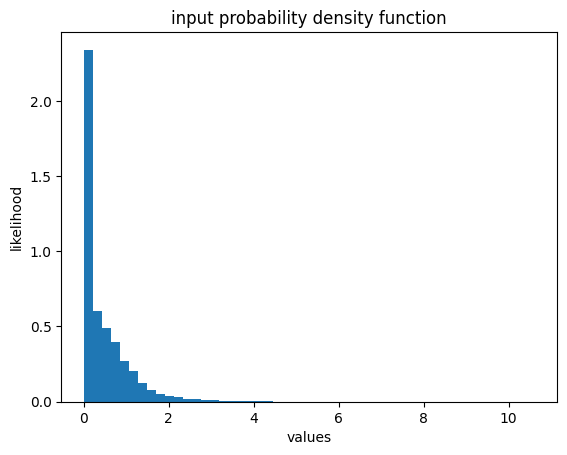

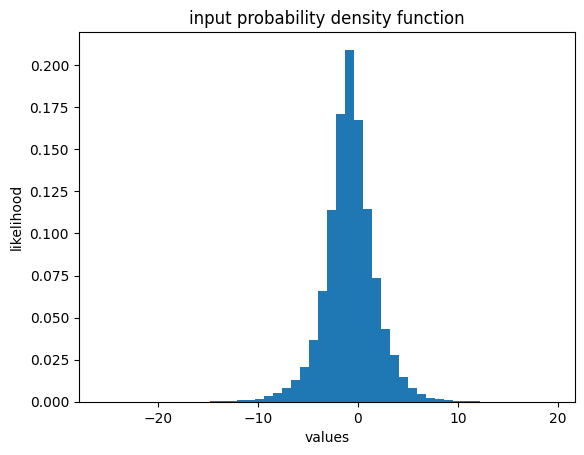

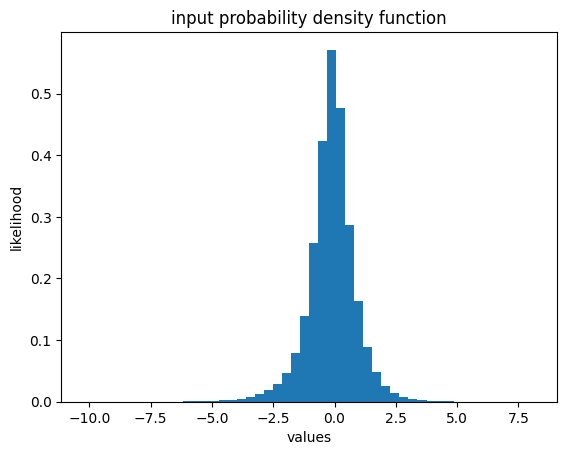

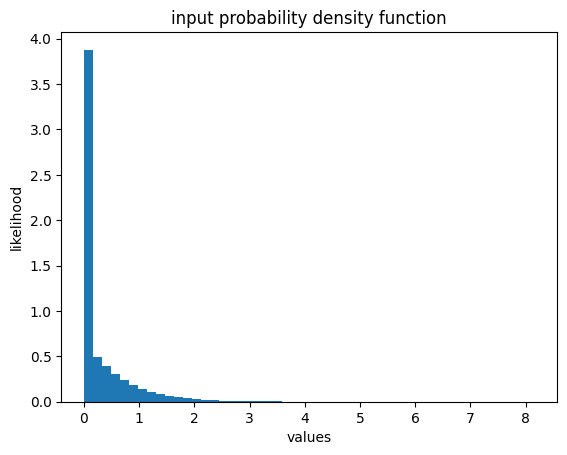

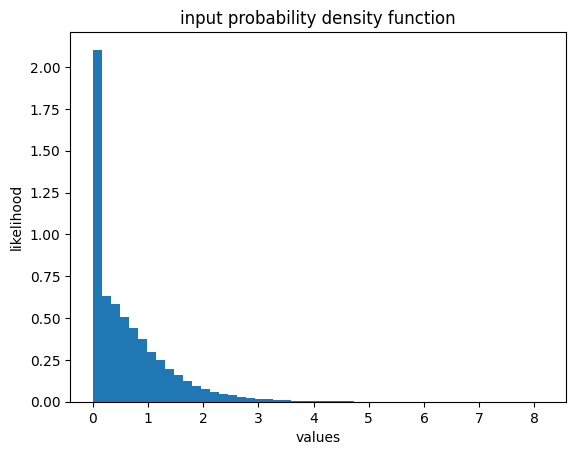

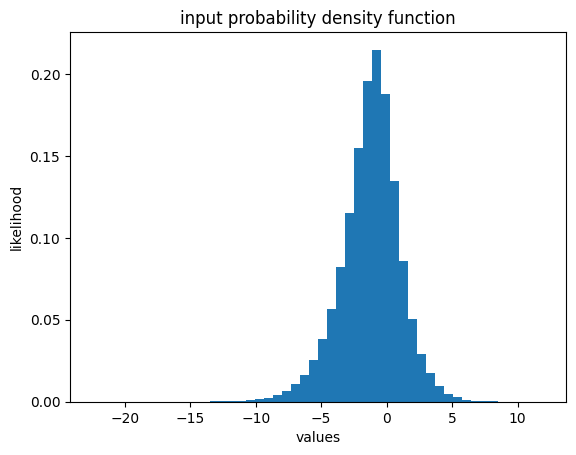

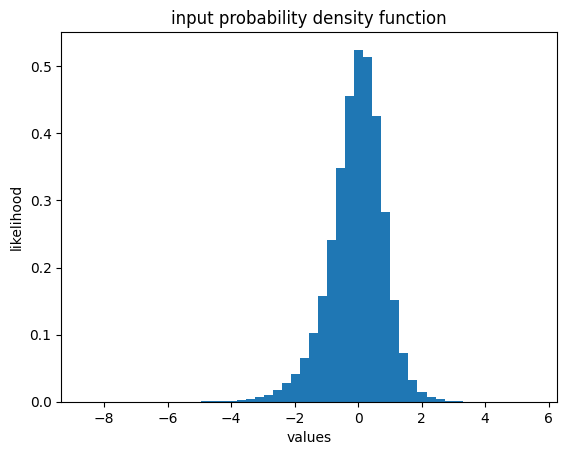

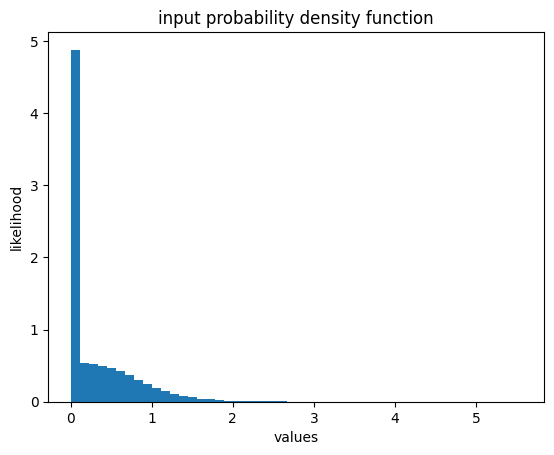

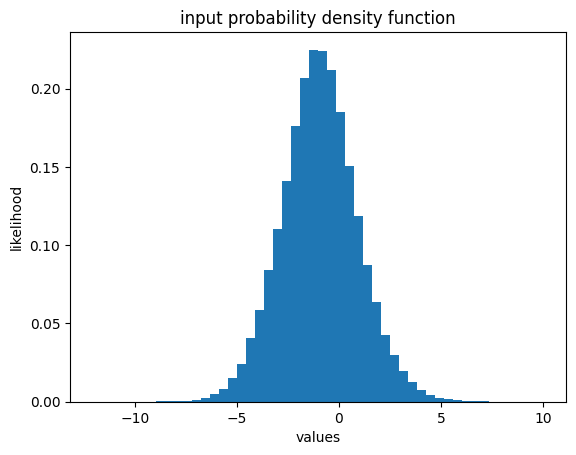

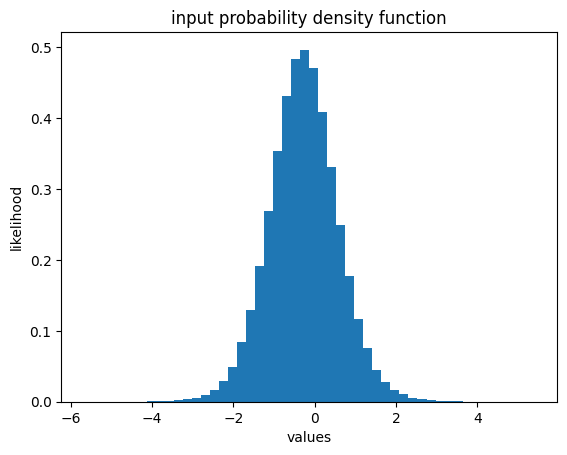

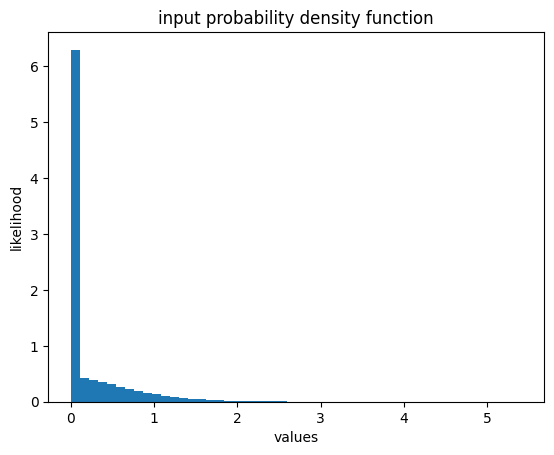

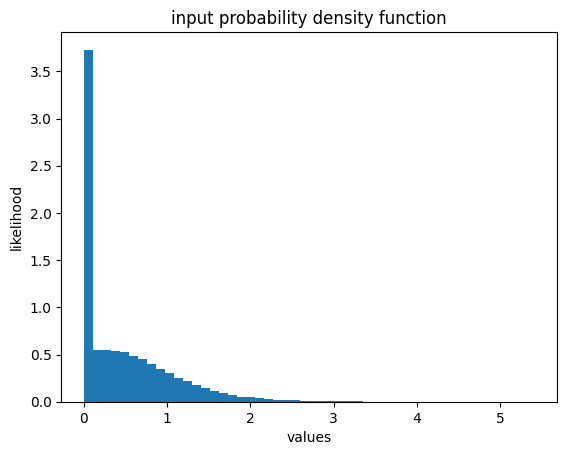

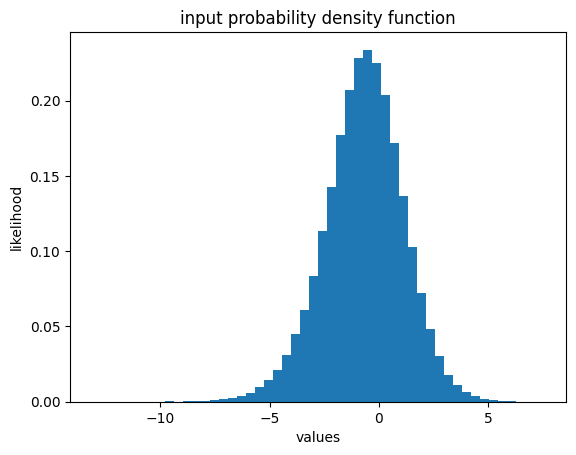

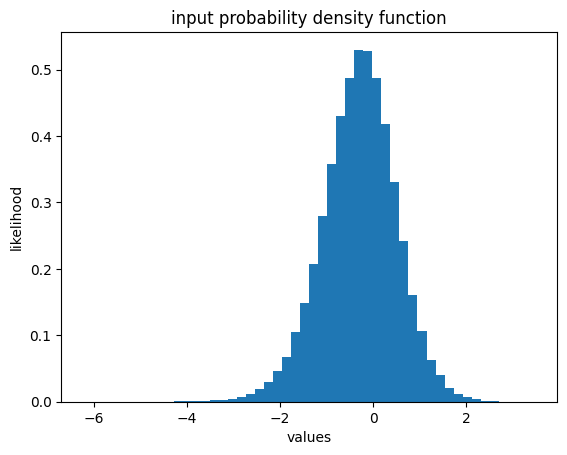

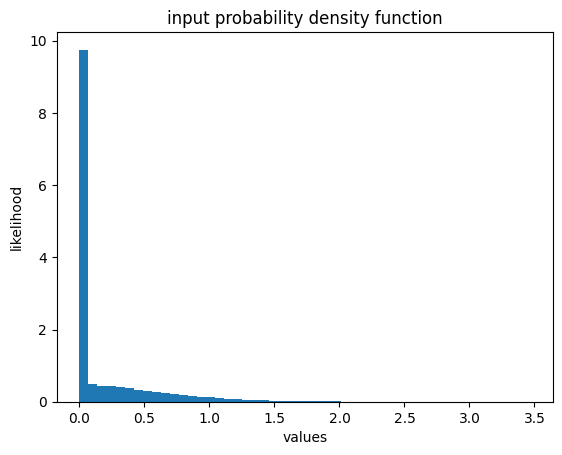

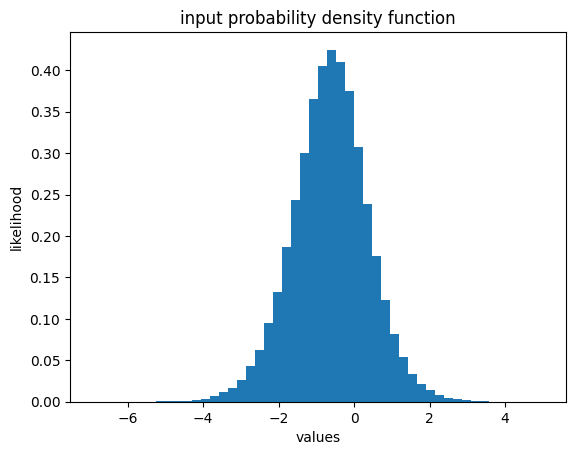

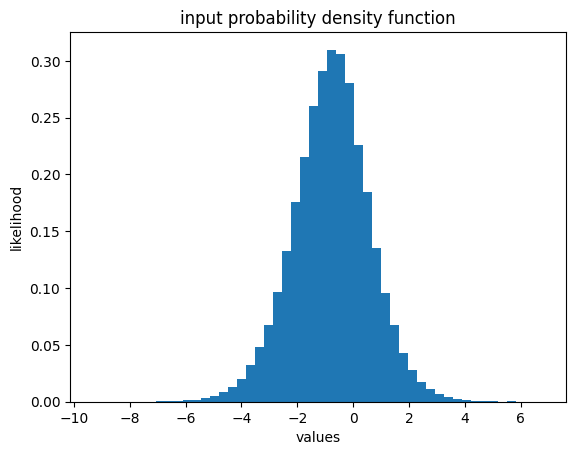

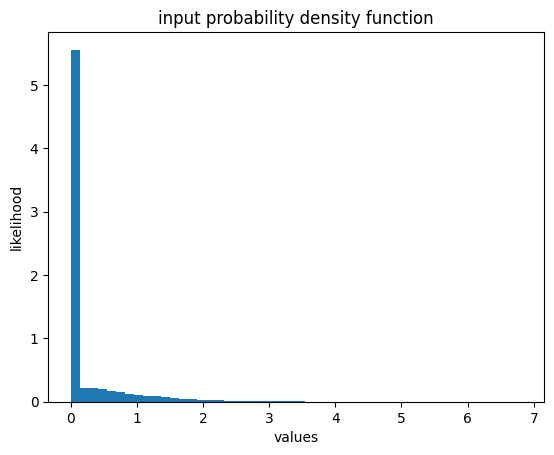

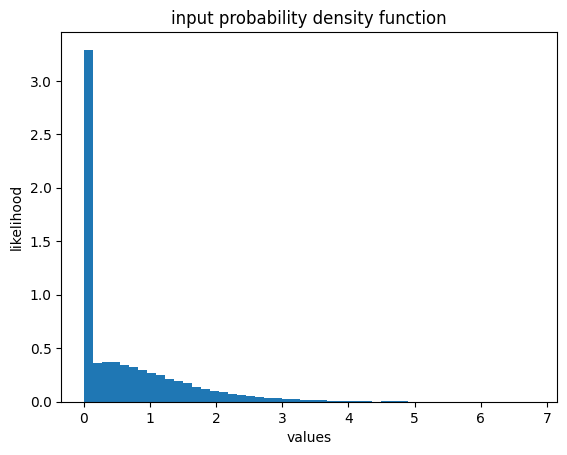

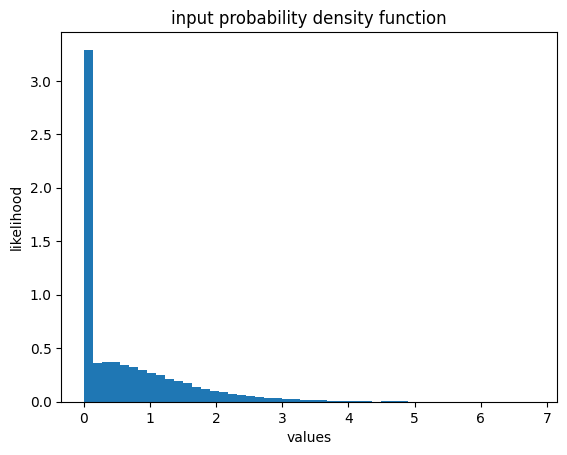

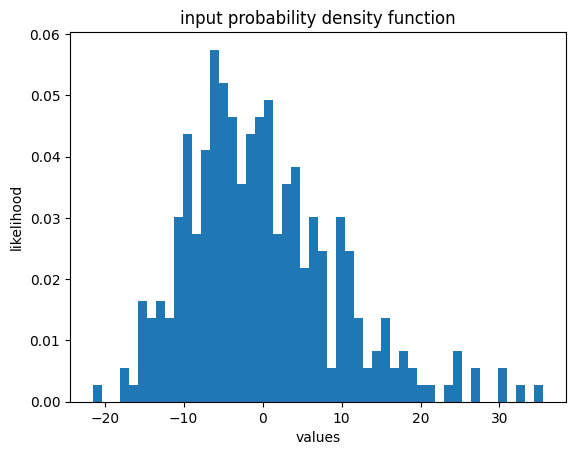

In [135]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def tensor_scale_asym(x):
    x_min = float(x.min())
    x_max = float(x.max())
    qmin, qmax = 0, 255 

    if x_max == x_min:
        return 1.0, 0

    scale = (x_max - x_min) / (qmax - qmin)
    zp = round(qmin - x_min / scale)
    zp = max(qmin, min(qmax, zp)) #clipping
    return scale, int(zp)

def plot_density(x):
    # input tensor x
    x = x.detach()
    plt.hist(x.flatten().numpy(), range=(float(x.min()),float(x.max())), density=True, bins=50)
    plt.title('input probability density function')
    plt.ylabel('likelihood')
    plt.xlabel('values')
    plt.show()
    

class CifarNetCalibration(CifarNet):
    def __init__(self):
        super(CifarNetCalibration, self).__init__()
        
        self.calibration_dict = {}
        
    def forward(self, x):
        self.calibration_dict["input_scale"] = tensor_scale(x)
        plot_density(x)
        x = self.conv1(x)
        plot_density(x)
        x = self.bn1(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv1_out_scale"], self.calibration_dict['conv1_zp'] = tensor_scale_asym(x)

        x = self.conv2(x)
        plot_density(x)
        x = self.bn2(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv2_out_scale"],self.calibration_dict['conv2_zp'] =  tensor_scale_asym(x)

        x = F.max_pool2d(x, 2, stride=2)
        plot_density(x)

        x = self.conv3(x)
        plot_density(x)
        x = self.bn3(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv3_out_scale"], self.calibration_dict['conv3_zp'] =  tensor_scale_asym(x)

        x = self.conv4(x)
        plot_density(x)
        x = self.bn4(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv4_out_scale"], self.calibration_dict['conv4_zp'] = tensor_scale_asym(x)

        x = F.max_pool2d(x, 2, stride=2)
        plot_density(x)

        x = self.conv5(x)
        plot_density(x)
        x = self.bn5(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv5_out_scale"], self.calibration_dict['conv5_zp'] =  tensor_scale_asym(x)

        x = self.conv6(x)
        plot_density(x)
        x = self.bn6(x)
        plot_density(x)
        x = F.relu(x)
        plot_density(x)
        self.calibration_dict["conv6_out_scale"], self.calibration_dict['conv6_zp'] =  tensor_scale_asym(x)

        x = F.max_pool2d(x, 2, stride=2)
        plot_density(x)

        x = torch.flatten(x, 1)
        plot_density(x)
        x = self.fc(x)
        plot_density(x)
        self.calibration_dict["fc_out_scale"] =  tensor_scale(x)

        return x
    
#We run the calibration using a batch from the testdata
net_calib = CifarNetCalibration()
net_calib.load_state_dict(torch.load('state_dict.pt'))
_, (data, _) = next(enumerate(testloader))
net_calib.forward(data)
calibration_dict = net_calib.calibration_dict

Your Task: 
* Copy Your code that sets the quantized state dict after calibration from the last lab. The state dict has now new entries `zero_point` for the fused conv and the fc layer.
* Explore what happens if we change the scale of the conv layer in a way that better suits the plots. Use the provided code to determine the accuracy for each step.
* After that, adjust the scale of the conv layers according to the figures

Your Task:
* After that, play around with scale and zero_point of the fully connected layer. What conclusion can we draw?

In [136]:
#prints keys from quantized net
qnet = QCifarNetNSym()
qsd = qnet.state_dict()
for key in qsd: print(key, qsd[key].dtype)
sd = torch.load('state_dict.pt')

###--- COPY YOUR IMPLEMENTATION HERE ---
for i in range(1, 7):
    conv_w = sd[f"conv{i}.weight"]
    conv_b = sd[f"conv{i}.bias"]
    bn_rm = sd[f"bn{i}.running_mean"]
    bn_rv = sd[f"bn{i}.running_var"]
    bn_w = sd[f"bn{i}.weight"]
    bn_b = sd[f"bn{i}.bias"]
    
    fused_conv_w, fused_conv_b = fuse_conv_bn_weights(conv_w, conv_b, bn_rm, bn_rv, bn_w, bn_b)
    
    qsd[f"conv{i}.weight"] = torch.quantize_per_tensor(fused_conv_w, 
                                                       tensor_scale(fused_conv_w), 
                                                       0, 
                                                       torch.qint8) 
    qsd[f"conv{i}.bias"] = fused_conv_b 
    
    print(f"Gewichtstyp conv{i}: {qsd[f'conv{i}.weight'].dtype}")
    print(f"Biasstyp conv{i}: {qsd[f'conv{i}.bias'].dtype}")
    
fc_w = sd["fc.weight"]
fc_b = sd["fc.bias"]

qsd["fc.weight"] = torch.quantize_per_tensor(fc_w, tensor_scale(fc_w), 0, torch.qint8)
qsd["fc.bias"] = fc_b

qsd['scale'] = torch.tensor(calibration_dict["input_scale"])
qsd['fc.scale'] = torch.tensor(calibration_dict["fc_out_scale"])
qsd['fc.zero_point'] = torch.tensor(0)

for i in range(1, 7):
    qsd[f"conv{i}.scale"] =torch.tensor(calibration_dict[f"conv{i}_out_scale"])
    qsd[f"conv{i}.zero_point"] = torch.tensor(calibration_dict[f"conv{i}_zp"])
    print(qsd[f"conv{i}.scale"])

### ------------------------------------

scale torch.float32
conv1.weight torch.qint8
conv1.bias torch.float32
conv1.scale torch.float32
conv1.zero_point torch.int64
conv2.weight torch.qint8
conv2.bias torch.float32
conv2.scale torch.float32
conv2.zero_point torch.int64
conv3.weight torch.qint8
conv3.bias torch.float32
conv3.scale torch.float32
conv3.zero_point torch.int64
conv4.weight torch.qint8
conv4.bias torch.float32
conv4.scale torch.float32
conv4.zero_point torch.int64
conv5.weight torch.qint8
conv5.bias torch.float32
conv5.scale torch.float32
conv5.zero_point torch.int64
conv6.weight torch.qint8
conv6.bias torch.float32
conv6.scale torch.float32
conv6.zero_point torch.int64
fc.weight torch.qint8
fc.bias torch.float32
fc.scale torch.float32
fc.zero_point torch.int64
torch.Size([16])
torch.Size([16])
torch.Size([16, 3, 3, 3])
Gewichtstyp conv1: torch.qint8
Biasstyp conv1: torch.float32
torch.Size([16])
torch.Size([16])
torch.Size([16, 16, 3, 3])
Gewichtstyp conv2: torch.qint8
Biasstyp conv2: torch.float32
torch.Size([32

In [137]:
#We run the accuracy test again to see how much accuracy we loose through quantization
print(f"Accuracy quantized: {net_acc(QCifarNetNSym, qsd, testloader):.4%}")

Accuracy quantized: 84.3750%
